In [1]:
train_dir = '/kaggle/input/covidnew/ALL/Train' 
val_dir = '/kaggle/input/covidnew/ALL/Train' 
test_dir = '/kaggle/input/covidnew/ALL/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 224,224 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

In [4]:
#LEEMOS LAS IMÁGENES 
from keras.applications.imagenet_utils import preprocess_input
img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255,
                                    #preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255)
                               #preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    subset='validation',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = val_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),

    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14461 images belonging to 2 classes.
Found 6196 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
train=train_generator
val=validation_generator
test=test_generator

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet152V2, NASNetLarge
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.applications import resnet_v2
from keras.applications import nasnet 

nasnet_model = nasnet.NASNetMobile(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

nasnet_model.trainable=False
for layer in nasnet_model.layers: 
    layer.trainable = False 

2023-02-08 16:56:32.205288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 16:56:32.298891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 16:56:32.299700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 16:56:32.301026: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

20004864/19993432 [==============================] - 0s 0us/step


In [7]:
#for layer in Xception_model.layers[:-40]:
#    layer.trainable = False

In [8]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in nasnet_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f738e71b9d0>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f738e50b3d0>,stem_conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f738c209b90>,stem_bn1,False
3,<keras.layers.core.Activation object at 0x7f738c54f710>,activation,False
4,<keras.layers.convolutional.Conv2D object at 0x7f738c54f590>,reduction_conv_1_stem_1,False
...,...,...,...
764,<keras.layers.merge.Add object at 0x7f737c125350>,normal_add_3_12,False
765,<keras.layers.merge.Add object at 0x7f737c113950>,normal_add_4_12,False
766,<keras.layers.merge.Add object at 0x7f737c10a950>,normal_add_5_12,False
767,<keras.layers.merge.Concatenate object at 0x7f737c167410>,normal_concat_12,False


In [9]:
nasnet_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [10]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [11]:
from keras.models import Model 
#from keras.applications.inception_resnet_v2 import preprocess_input
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers 

# build model architecture 
model = Sequential()
model.add(nasnet_model)
model.add(Flatten())

model.add(Dense(num_class, activation='sigmoid'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
flatten (Flatten)            (None, 51744)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 103490    
Total params: 4,373,206
Trainable params: 103,490
Non-trainable params: 4,269,716
_________________________________________________________________
None


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
history = model.fit_generator(train, 
                              epochs=10,  
                              validation_data=val,  
                              verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-02-08 16:56:42.321406: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '
2023-02-08 16:56:56.440981: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


452/452 [==============================] - 200s 401ms/step - loss: 0.2820 - accuracy: 0.8805 - f1_m: 0.8260 - precision_m: 0.9051 - recall_m: 0.7635 - val_loss: 0.1670 - val_accuracy: 0.9300 - val_f1_m: 0.8867 - val_precision_m: 0.9484 - val_recall_m: 0.8343
Epoch 2/10
452/452 [==============================] - 68s 151ms/step - loss: 0.1807 - accuracy: 0.9257 - f1_m: 0.8912 - precision_m: 0.9471 - recall_m: 0.8437 - val_loss: 0.1442 - val_accuracy: 0.9416 - val_f1_m: 0.9167 - val_precision_m: 0.9566 - val_recall_m: 0.8816
Epoch 3/10
452/452 [==============================] - 71s 158ms/step - loss: 0.1469 - accuracy: 0.9430 - f1_m: 0.9098 - precision_m: 0.9584 - recall_m: 0.8678 - val_loss: 0.1295 - val_accuracy: 0.9475 - val_f1_m: 0.9199 - val_precision_m: 0.9618 - val_recall_m: 0.8831
Epoch 4/10
452/452 [==============================] - 68s 151ms/step - loss: 0.1246 - accuracy: 0.9506 - f1_m: 0.9225 - precision_m: 0.9649 - recall_m: 0.8853 - val_loss: 0.1348 - val_accuracy: 0.9466 - 

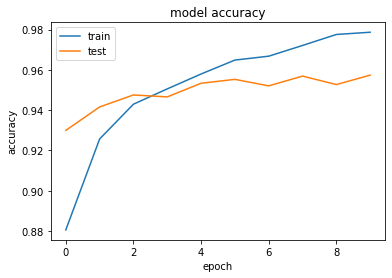

In [13]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

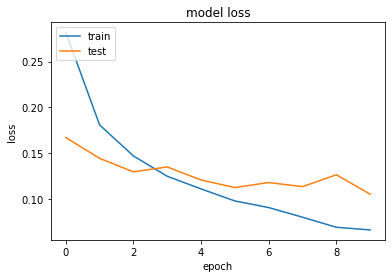

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

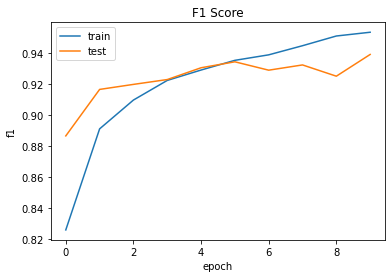

In [15]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

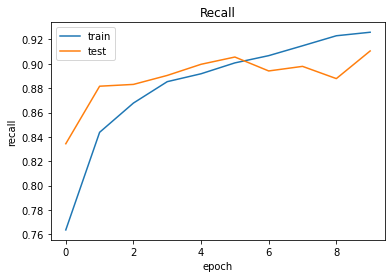

In [16]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

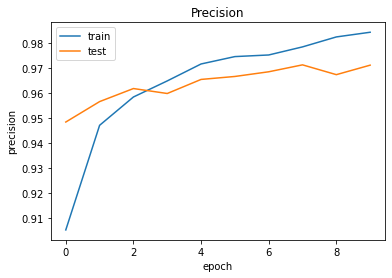

In [17]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
63/63 [==============================] - 17s 269ms/step - loss: 0.1267 - accuracy: 0.9545 - f1_m: 0.9239 - precision_m: 0.9618 - recall_m: 0.8904
El modelo predice el  95.45000195503235 % de los datos


In [19]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.12668666243553162
Accuracy:  0.9545000195503235
F1 Score:  0.9239055514335632
Precision:  0.9618057608604431
Recall:  0.8903769850730896
